<a href="https://colab.research.google.com/github/senriquez2/Final-Project/blob/main/Volcano_Plot_Heatmapt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats

In [2]:
github_raw_url = 'https://raw.githubusercontent.com/senriquez2/Final-Project/refs/heads/main/Data_Final.csv'
df = pd.read_csv(github_raw_url)


In [3]:
#file_path = 'Data_Final.xlsx'

#df = pd.read_excel(file_path)

# Clean column names by replacing multiple spaces with a single space and stripping
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()

# Verify it loaded
#print(df.head())

In [4]:
# 1. SETUP THE COMPARISONS
comparisons = [
    {'name': 'A30P', 'case': ['Alpha A30P_day_10_1', 'Alpha A30P_day_10_2'], 'ctrl': ['Alpha _day_10_1', 'Alpha _day_10_2']},
    {'name': 'A53T', 'case': ['Alpha A53T_day_10_1', 'Alpha A53T_day_10_2'], 'ctrl': ['Alpha _day_10_1', 'Alpha _day_10_2']}
]

/tmp/ipython-input-2543152962.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
/tmp/ipython-input-2543152962.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['Gene names'] = df_processed['Gene names'].astype(str)


df_processed columns (after numeric conversion): ['Alpha A30P_day_1_1', 'Alpha A30P_day_1_2', 'Alpha A30P_day_10_1', 'Alpha A30P_day_10_2', 'Alpha A53T_day_1_1', 'Alpha A53T_day_1_2', 'Alpha A53T_day_10_1', 'Alpha A53T_day_10_2', 'Alpha A53T_day_30_1', 'Alpha A53T_day_30_2', 'Alpha _day_1_1', 'Alpha _day_1_2', 'Alpha _day_10_1', 'Alpha _day_10_2', 'Alpha _day_30_1', 'Alpha _day_30_2', 'Gene names']
df_processed dtypes:
 Alpha A30P_day_1_1     float64
Alpha A30P_day_1_2     float64
Alpha A30P_day_10_1    float64
Alpha A30P_day_10_2    float64
Alpha A53T_day_1_1     float64
Alpha A53T_day_1_2     float64
Alpha A53T_day_10_1    float64
Alpha A53T_day_10_2    float64
Alpha A53T_day_30_1    float64
Alpha A53T_day_30_2    float64
Alpha _day_1_1         float64
Alpha _day_1_2         float64
Alpha _day_10_1        float64
Alpha _day_10_2        float64
Alpha _day_30_1        float64
Alpha _day_30_2        float64
Gene names              object
dtype: object
--- ALL COLUMN NAMES IN DF_LOG2 ---

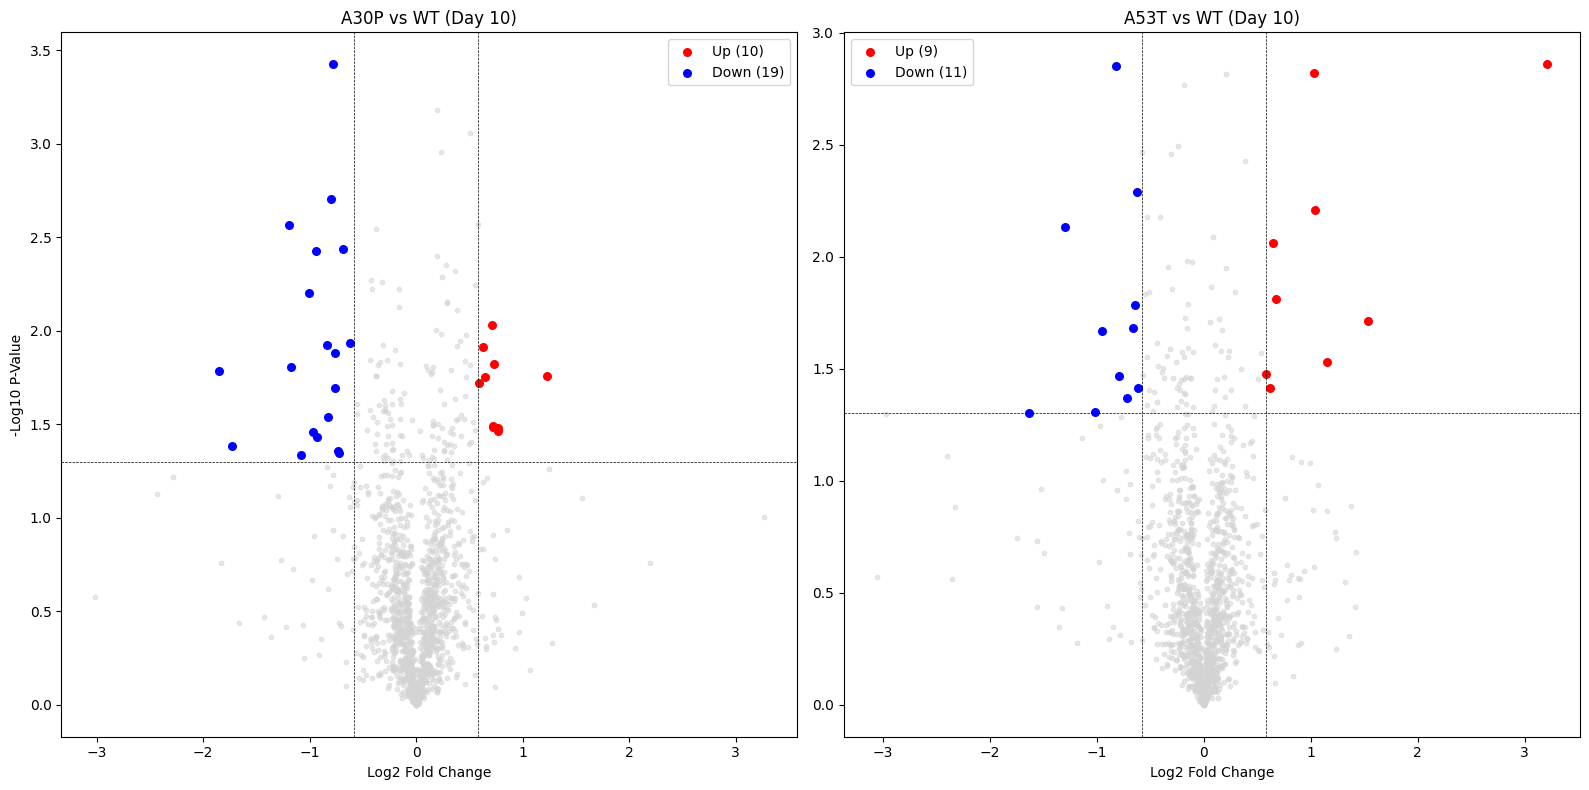

In [5]:


# 2. RUN LOOP FOR BOTH MUTANTS
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Drop rows where 'Gene names' is NaN
df_processed = df.dropna(subset=['Gene names'])

# Ensure all data columns are numeric, coercing errors
for col in df_processed.columns:
    if col != 'Gene names': # Don't try to convert 'Gene names' to numeric
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

# Convert 'Gene names' to string type to prevent sorting errors in groupby
df_processed['Gene names'] = df_processed['Gene names'].astype(str)

# Debugging: Print df_processed columns after numeric conversion
print("df_processed columns (after numeric conversion):", df_processed.columns.tolist())
print("df_processed dtypes:\n", df_processed.dtypes)


# Aggregate duplicates by taking the mean of numeric columns
df_log2 = df_processed.groupby('Gene names').mean(numeric_only=True)

# Run this right after df_log2 is defined
print("--- ALL COLUMN NAMES IN DF_LOG2 ---")
print(df_log2.columns.tolist())

# Debugging: Print df_log2 columns after groupby
print("df_log2 columns (after groupby and numeric_only=True):", df_log2.columns.tolist())


# Apply log2 transformation to numerical columns only
df_log2 = df_log2.apply(lambda x: np.log2(x) if np.issubdtype(x.dtype, np.number) else x)

for i, comp in enumerate(comparisons):
    ax = axes[i]
    mutant_name = comp['name']

    # Debugging print statement for columns in df_log2
    print(f"Columns in df_log2 before accessing for {mutant_name}: {df_log2.columns.tolist()}")
    print(f"Case columns for {mutant_name}: {comp['case']}")
    print(f"Control columns for {mutant_name}: {comp['ctrl']}")

    # Run Stats
    results = []
    for gene in df_log2.index:
        # Check if gene exists in df_log2's index
        if gene not in df_log2.index:
            continue

        # Problematic line
        case_vals = df_log2.loc[gene, comp['case']].dropna()
        ctrl_vals = df_log2.loc[gene, comp['ctrl']].dropna()

        if len(case_vals) < 2 or len(ctrl_vals) < 2: continue

        # Calculate Difference
        log2fc = case_vals.mean() - ctrl_vals.mean()
        # Calculate Significance (P-value)
        _, p_val = stats.ttest_ind(case_vals, ctrl_vals, equal_var=False)

        results.append({'Log2FC': log2fc, 'P_Value': p_val})

    res_df = pd.DataFrame(results)
    res_df['NegLogP'] = -np.log10(res_df['P_Value'])

    # Filter Hits (P<0.05, FC>0.58)
    alpha = 0.05
    fc_cut = 0.58
    ups = res_df[(res_df.P_Value < alpha) & (res_df.Log2FC > fc_cut)]
    downs = res_df[(res_df.P_Value < alpha) & (res_df.Log2FC < -fc_cut)]

    # Plot
    ax.scatter(res_df.Log2FC, res_df.NegLogP, c='lightgrey', s=10, alpha=0.5)
    ax.scatter(ups.Log2FC, ups.NegLogP, c='red', s=30, label=f'Up ({len(ups)})')
    ax.scatter(downs.Log2FC, downs.NegLogP, c='blue', s=30, label=f'Down ({len(downs)})')

    # Add Lines
    ax.axvline(fc_cut, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(-fc_cut, color='k', linestyle='--', linewidth=0.5)
    ax.axhline(-np.log10(alpha), color='k', linestyle='--', linewidth=0.5)

    ax.set_title(f'{mutant_name} vs WT (Day 10)')
    ax.set_xlabel('Log2 Fold Change')
    if i == 0: ax.set_ylabel('-Log10 P-Value')
    ax.legend()

plt.tight_layout()
plt.show()

<Figure size 1400x1200 with 0 Axes>

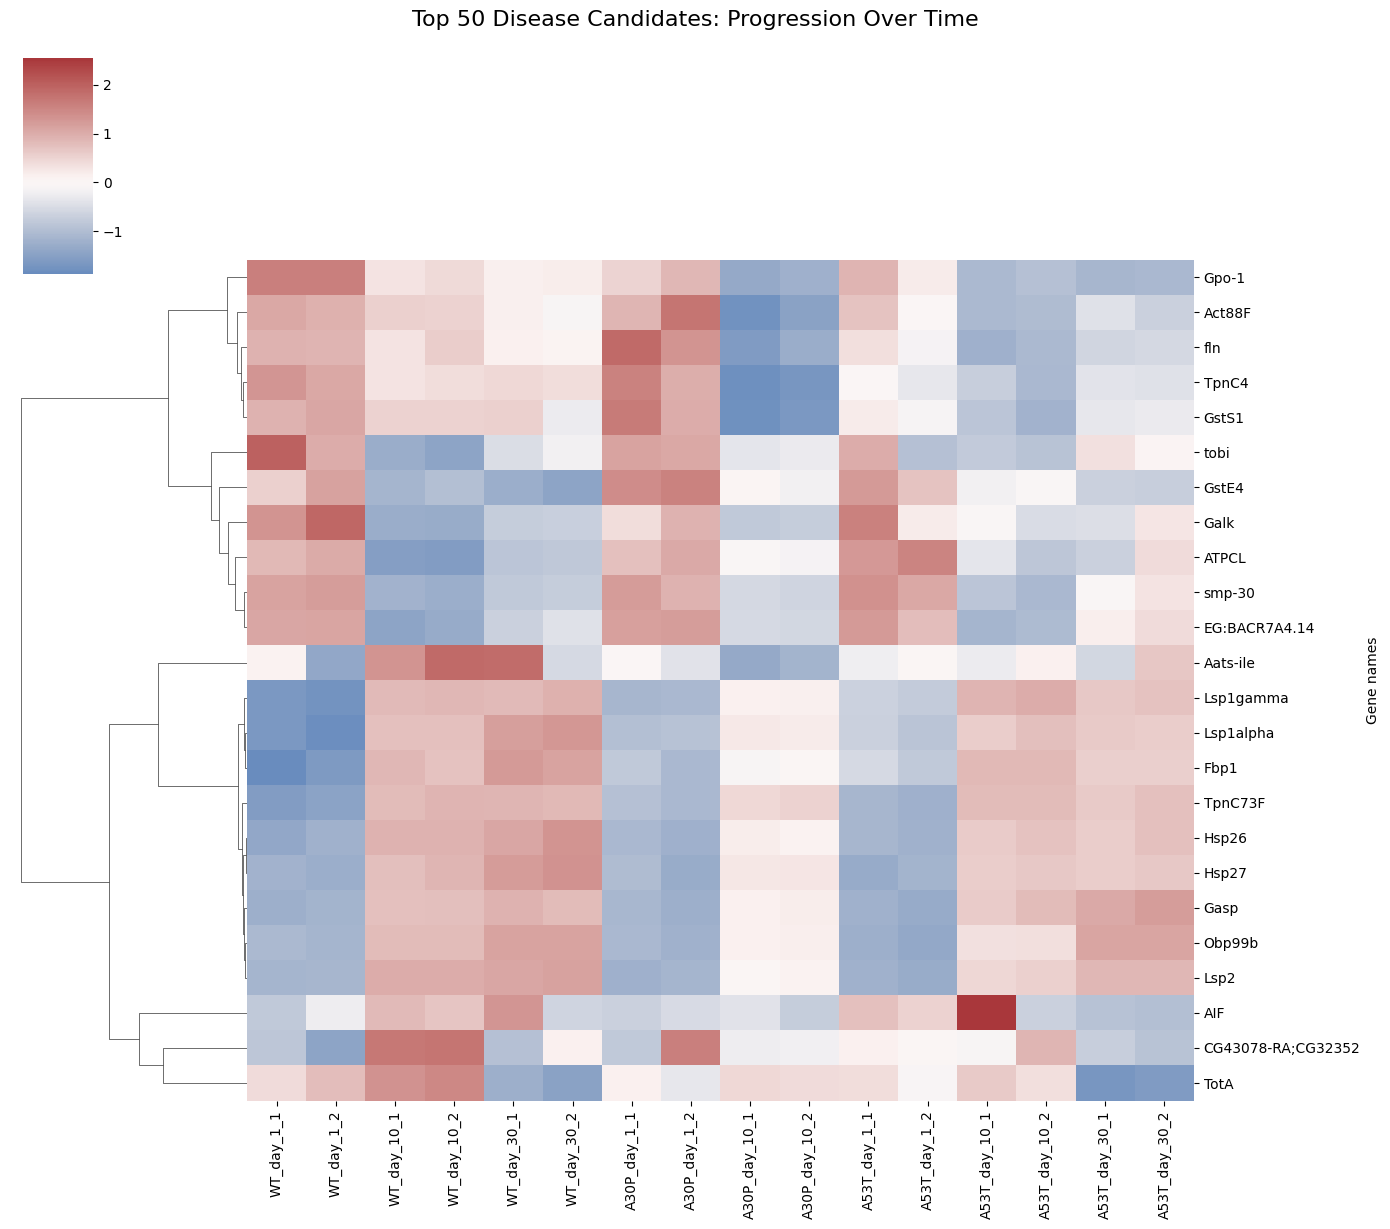

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# --- 0. CRITICAL RENAME FIX (From previous steps) ---
rename_map = {
    'Alpha A30P_day_1_1': 'A30P_day_1_1', 'Alpha A30P_day_1_2': 'A30P_day_1_2',
    'Alpha A30P_day_10_1': 'A30P_day_10_1', 'Alpha A30P_day_10_2': 'A30P_day_10_2',
    'Alpha A53T_day_1_1': 'A53T_day_1_1', 'Alpha A53T_day_1_2': 'A53T_day_1_2',
    'Alpha A53T_day_10_1': 'A53T_day_10_1', 'Alpha A53T_day_10_2': 'A53T_day_10_2',
    'Alpha A53T_day_30_1': 'A53T_day_30_1', 'Alpha A53T_day_30_2': 'A53T_day_30_2',
    'Alpha _day_1_1': 'WT_day_1_1', 'Alpha _day_1_2': 'WT_day_1_2',
    'Alpha _day_10_1': 'WT_day_10_1', 'Alpha _day_10_2': 'WT_day_10_2',
    'Alpha _day_30_1': 'WT_day_30_1', 'Alpha _day_30_2': 'WT_day_30_2'
}
df_log2 = df_log2.rename(columns=rename_map)

# --- 1. RE-CALCULATE STATS (Define stats_df) ---
case = ['A30P_day_10_1', 'A30P_day_10_2']
ctrl = ['WT_day_10_1', 'WT_day_10_2']
stats_results = []
for gene in df_log2.index:
    case_vals = df_log2.loc[gene, case].dropna()
    ctrl_vals = df_log2.loc[gene, ctrl].dropna()
    if len(case_vals) < 2 or len(ctrl_vals) < 2: continue

    _, p_val = stats.ttest_ind(case_vals, ctrl_vals, equal_var=False)
    log2fc = case_vals.mean() - ctrl_vals.mean()
    stats_results.append({'Gene': gene, 'P_Value': p_val, 'Log2FC': log2fc})

stats_df = pd.DataFrame(stats_results)

# 2. IDENTIFY TOP 50 GENES
alpha_cut = 0.05
fc_cut = 0.58
sig_df = stats_df[(stats_df.P_Value < alpha_cut) & (np.abs(stats_df.Log2FC) > fc_cut)]
top_genes = sig_df.sort_values('P_Value').head(50)['Gene'].values

# --- 3. HEATMAP GENERATION ---
if len(top_genes) == 0:
    print("Error: No significant genes found based on your cutoffs (P<0.05, |FC|>0.58).")
else:
    # 3a. EXTRACT DATA
    heatmap_data = df_log2.loc[top_genes]

    # CRITICAL FIX: Drop any gene that still contains a missing value across its profile
    # The clustering algorithm requires ALL data to be finite numbers.
    heatmap_data = heatmap_data.dropna(axis=0)

    # Check again if we still have genes
    if heatmap_data.shape[0] < 2:
        print(f"Error: Only {heatmap_data.shape[0]} gene(s) remaining after dropping NaNs. Cannot cluster.")

    # 3b. DEFINE THE CORRECT SORTING LOGIC (Genotype -> Day -> Replicate)
    def sort_key(col_name):
        parts = col_name.split('_')
        genotype = parts[0]
        day = int(parts[2])
        replicate = int(parts[3])
        gt_order = {'WT': 0, 'A30P': 1, 'A53T': 2}
        return (gt_order.get(genotype, 99), day, replicate)

    # Apply the sorting key to the columns
    sorted_cols = sorted(heatmap_data.columns, key=sort_key)
    heatmap_data = heatmap_data[sorted_cols]

    # 3c. PLOT
    plt.figure(figsize=(14, 12))
    sns.clustermap(heatmap_data,
               col_cluster=False,
               row_cluster=True,
               z_score=0,
               cmap='vlag',
               center=0,
               metric='correlation',  # <--- Use correlation to group genes
               figsize=(14, 12))

    plt.suptitle('Top 50 Disease Candidates: Progression Over Time', y=1.02, fontsize=16)
    plt.show()



In [7]:
# Print the names of the Top 10 most significant genes
top_10 = stats_df.sort_values('P_Value').head(10)
print(top_10[['Gene', 'Log2FC', 'P_Value']])

                    Gene    Log2FC   P_Value
210   CG43078-RA;CG32352 -0.781391  0.000375
173               CG2649  0.198587  0.000662
1320                 pug  0.506025  0.000877
524                Hex-C  0.236462  0.001103
1011               TpnC4 -0.801493  0.001963
1022                Tsf1  0.577131  0.002694
683               Obp99b -1.189657  0.002715
640                 ND42 -0.373328  0.002844
497                Gpo-1 -0.686676  0.003665
602            Lsp1gamma -0.939293  0.003737


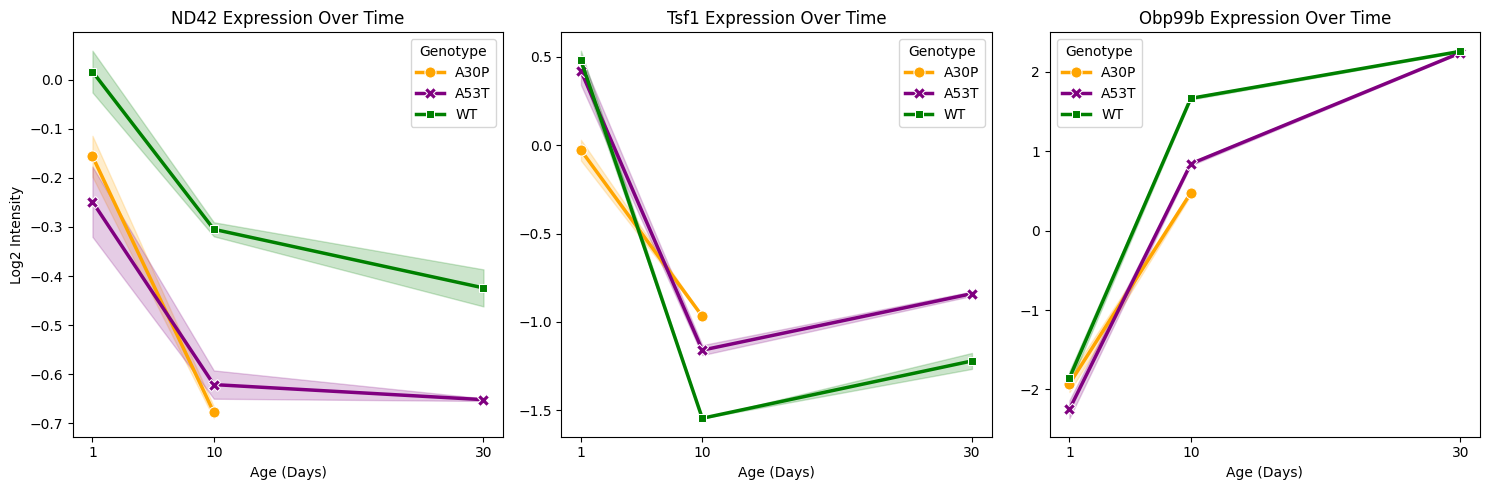

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. CHOOSE YOUR CHARACTERS
# These are the genes you just identified as the most important storytellers.
# (Make sure these names match exactly what was in your print output)
targets = ['ND42', 'Tsf1', 'Obp99b']

# 2. PREPARE DATA FOR PLOTTING
# We use the 'plot_data' we created way back in the QC step (Long format)
# If you don't have it, we recreate it quickly:
plot_data = df_log2.reset_index().melt(id_vars='Gene names', var_name='Sample', value_name='Log2 Intensity')
plot_data['Genotype'] = plot_data['Sample'].str.split('_').str[0]
plot_data['Day'] = plot_data['Sample'].str.split('_').str[2].astype(int)

# 3. PLOT
plt.figure(figsize=(15, 5))

for i, gene in enumerate(targets):
    plt.subplot(1, 3, i+1)

    # Filter for just this one gene
    gene_data = plot_data[plot_data['Gene names'] == gene]

    if len(gene_data) == 0:
        print(f"Warning: {gene} not found in data.")
        continue

    # Plot Lines (Mean + Error Bars)
    sns.lineplot(data=gene_data, x='Day', y='Log2 Intensity', hue='Genotype',
                 style='Genotype', markers=True, dashes=False,
                 palette={'WT': 'green', 'A30P': 'orange', 'A53T': 'purple'},
                 linewidth=2.5, markersize=8)

    plt.title(f'{gene} Expression Over Time')
    plt.ylabel('Log2 Intensity')
    plt.xlabel('Age (Days)')
    plt.xticks([1, 10, 30]) # Force x-axis to show real days
    if i > 0: plt.ylabel('') # Hide y-label for middle plots to save space

plt.tight_layout()
plt.show()